In [1]:
###### Task 1: Term Deposit Subscription Prediction

### Objective
# Predict whether a bank customer will subscribe to a term deposit (yes/no) based on marketing campaign data.

### Dataset
# - Source: [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing)
# - Rows: 45,211
# - Features: 16 (e.g., age, job, contact, balance, duration)
# - Target: `y` → "yes" if subscribed, "no" otherwise

In [2]:
# Importing the essential libraries for the task

# For data manipulation and analysis
import pandas as pd
import numpy as np

# For creating graphs and visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Encoding variables as binary ( 0/1 )
from sklearn.preprocessing import OneHotEncoder

# Splits the data into training and testing data
from sklearn.model_selection import train_test_split

# To apply different preprocessing steps to specific columns in  a DataFrame
from sklearn.compose import ColumnTransformer

# To build different decision trees and merge them to get more accurate predictions
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, f1_score

# Method to explain model predictions by attibuting importance to each feature
import shap

In [3]:
# Load the dataset
df=pd.read_csv("bankb-full.csv", sep=";")

# Displaying first 5 rows
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
# Showing dataset basic info
print(f"The Dataset shape is: {df.shape}")
print(df.describe())
df.dtypes

The Dataset shape is: (45211, 17)
                age        balance           day      duration      campaign  \
count  45211.000000   45211.000000  45211.000000  45211.000000  45211.000000   
mean      40.936210    1362.272058     15.806419    258.163080      2.763841   
std       10.618762    3044.765829      8.322476    257.527812      3.098021   
min       18.000000   -8019.000000      1.000000      0.000000      1.000000   
25%       33.000000      72.000000      8.000000    103.000000      1.000000   
50%       39.000000     448.000000     16.000000    180.000000      2.000000   
75%       48.000000    1428.000000     21.000000    319.000000      3.000000   
max       95.000000  102127.000000     31.000000   4918.000000     63.000000   

              pdays      previous  
count  45211.000000  45211.000000  
mean      40.197828      0.580323  
std      100.128746      2.303441  
min       -1.000000      0.000000  
25%       -1.000000      0.000000  
50%       -1.000000      0.00

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

y
no     39922
yes     5289
Name: count, dtype: int64
y
no     88.30152
yes    11.69848
Name: proportion, dtype: float64


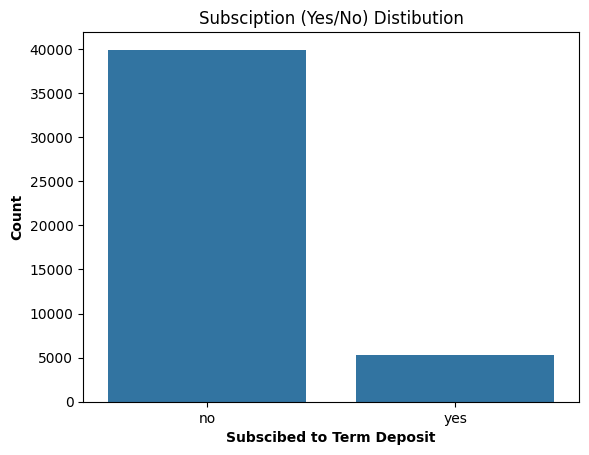

In [5]:
# Checking the total number of yes and no in the y column to see if it is balanced
print(df["y"].value_counts())
print(df["y"].value_counts(normalize=True)*100)

sns.countplot(data=df,x="y")
plt.title("Subsciption (Yes/No) Distibution")
plt.xlabel("Subscibed to Term Deposit", fontweight="bold")
plt.ylabel("Count", fontweight="bold")
plt.show()

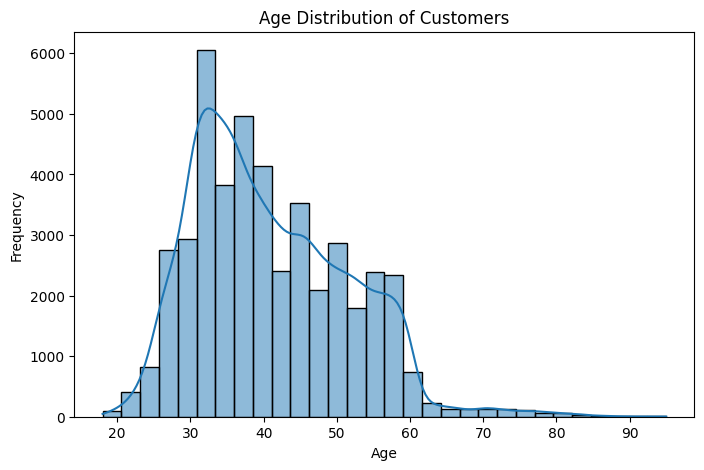

In [6]:
# Age distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['age'], bins=30, kde=True)
plt.title('Age Distribution of Customers')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

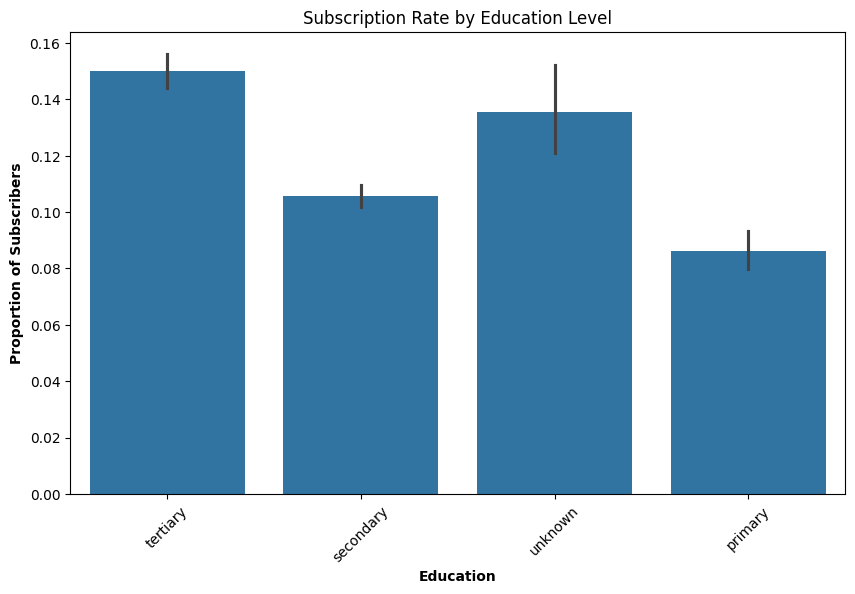

In [7]:
# Subscription rate by education level
# Convert 'y' to numeric for averaging
df_temp = df.copy()
df_temp['subscribed'] = (df_temp['y'] == 'yes').astype(int)

# Plot average subscription rate by education
plt.figure(figsize=(10, 6))
sns.barplot(data=df_temp, x='education', y='subscribed')
plt.title('Subscription Rate by Education Level')
plt.xlabel('Education', fontweight="bold")
plt.ylabel('Proportion of Subscribers', fontweight="bold")
plt.xticks(rotation=45)
plt.show()

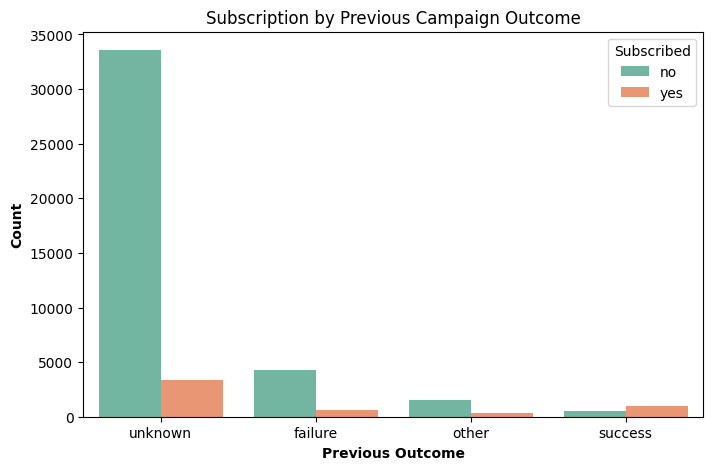

In [8]:
# Subscription by previous outcome (poutcome)
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='poutcome', hue='y', palette='Set2')
plt.title('Subscription by Previous Campaign Outcome')
plt.xlabel('Previous Outcome', fontweight="bold")
plt.ylabel('Count', fontweight="bold")
plt.legend(title='Subscribed')
plt.show()

In [9]:
# Separate features (X) and target (y)
X = df.drop('y', axis=1) 

# Convert 'yes'/'no' to 1/0
y = df['y'].map({'no': 0, 'yes': 1})  

# Identify categorical columns (text-based)
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

In [10]:
# Use ColumnTransformer to apply One-Hot Encoding to categorical columns
preprocessor = ColumnTransformer(
    transformers=[('encoder', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), categorical_cols)],remainder='passthrough')

# Fit and transform the data
X_processed = preprocessor.fit_transform(X)  

# Confirm shape after encoding
print(f"Shape after encoding: {X_processed.shape}")

Shape after encoding: (45211, 42)


In [11]:
# Now split the train and test data (80%-20%)
X_train, X_test, Y_train, Y_test=train_test_split(X_processed, y, test_size=0.2, stratify=y)

In [12]:
# Initialize and train Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, Y_train)

# Make predictions
y_pred = model.predict(X_test)

# Probability of 'yes'
y_pred_proba = model.predict_proba(X_test)[:, 1]  

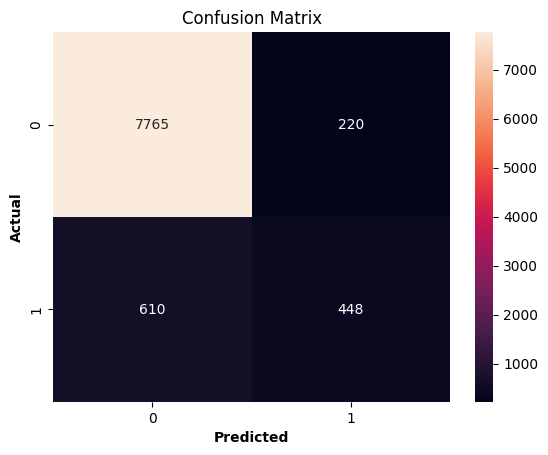

In [13]:
# Confusion Matrix
cm = confusion_matrix(Y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted', fontweight="bold")
plt.ylabel('Actual', fontweight="bold")
plt.show()

In [14]:
# F1-Score and Classification Report
f1 = f1_score(Y_test, y_pred)
print(f"F1-Score: {f1:.4f}\n")
print("Classification Report:")
print(classification_report(Y_test, y_pred))

F1-Score: 0.5191

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      7985
           1       0.67      0.42      0.52      1058

    accuracy                           0.91      9043
   macro avg       0.80      0.70      0.73      9043
weighted avg       0.90      0.91      0.90      9043



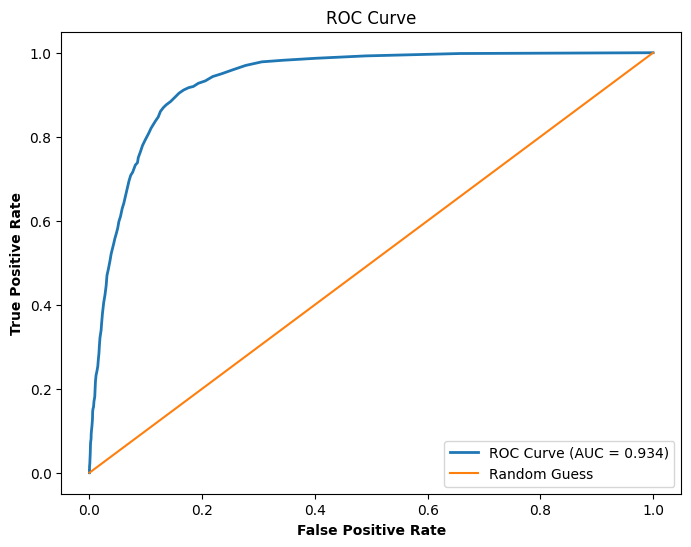

In [15]:
# ROC Curve
fpr, tpr, _ = roc_curve(Y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], label='Random Guess')
plt.xlabel('False Positive Rate', fontweight="bold")
plt.ylabel('True Positive Rate', fontweight="bold")
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [16]:
# --- Step 1: Get real feature names ---
encoder = preprocessor.named_transformers_['encoder']
cat_features = encoder.get_feature_names_out(categorical_cols)
num_features = [col for col in X.columns if col not in categorical_cols]
feature_names = list(cat_features) + num_features

In [17]:
# --- Step 2: Create X_test DataFrame ---
X_test_df = pd.DataFrame(X_test, columns=feature_names)

In [18]:
# --- Step 3: Compute SHAP values ---
explainer = shap.TreeExplainer(model)
shap_values_list = explainer.shap_values(X_test_df.iloc[:5])
shap_values = shap_values_list[1]  # "yes" class

In [19]:
# --- Step 4: Only use the first 2 features (because SHAP has only 2 values) ---
n_shap = shap_values.shape[1]  
used_features = X_test_df.iloc[:5].iloc[:, :n_shap]  
used_feature_names = feature_names[:n_shap]  


--- Prediction #1 ---
Predicted probability of 'yes': 0.020


/home/umer/dev_intern/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/umer/dev_intern/venv/lib/python3.13/site-packages/shap/plots/_force_matplotlib.py:107: RuntimeWarning: divide by zero encountered in scalar divide
  feature_contribution = np.abs(float(feature[0]) - pre_val) / np.abs(total_effect)


<Figure size 1000x400 with 0 Axes>

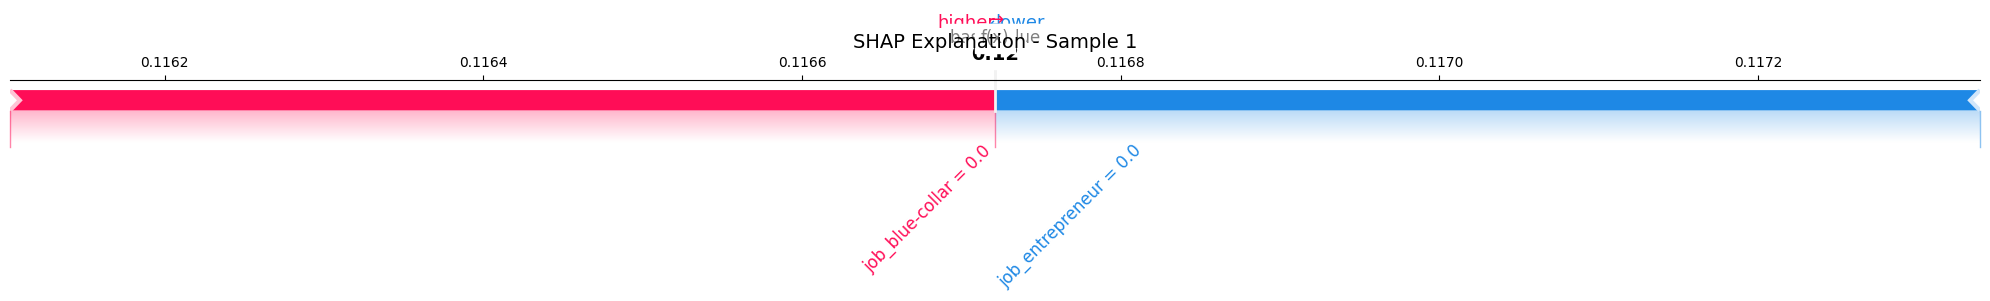


--- Prediction #2 ---
Predicted probability of 'yes': 0.000


/home/umer/dev_intern/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/umer/dev_intern/venv/lib/python3.13/site-packages/shap/plots/_force_matplotlib.py:107: RuntimeWarning: divide by zero encountered in scalar divide
  feature_contribution = np.abs(float(feature[0]) - pre_val) / np.abs(total_effect)


<Figure size 1000x400 with 0 Axes>

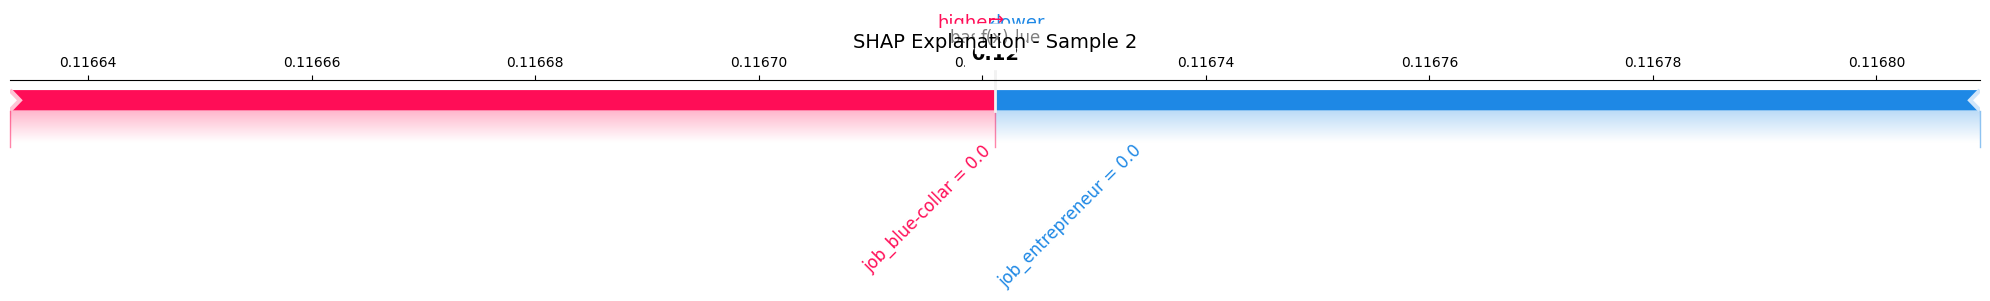


--- Prediction #3 ---
Predicted probability of 'yes': 0.100


/home/umer/dev_intern/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/umer/dev_intern/venv/lib/python3.13/site-packages/shap/plots/_force_matplotlib.py:107: RuntimeWarning: divide by zero encountered in scalar divide
  feature_contribution = np.abs(float(feature[0]) - pre_val) / np.abs(total_effect)


<Figure size 1000x400 with 0 Axes>

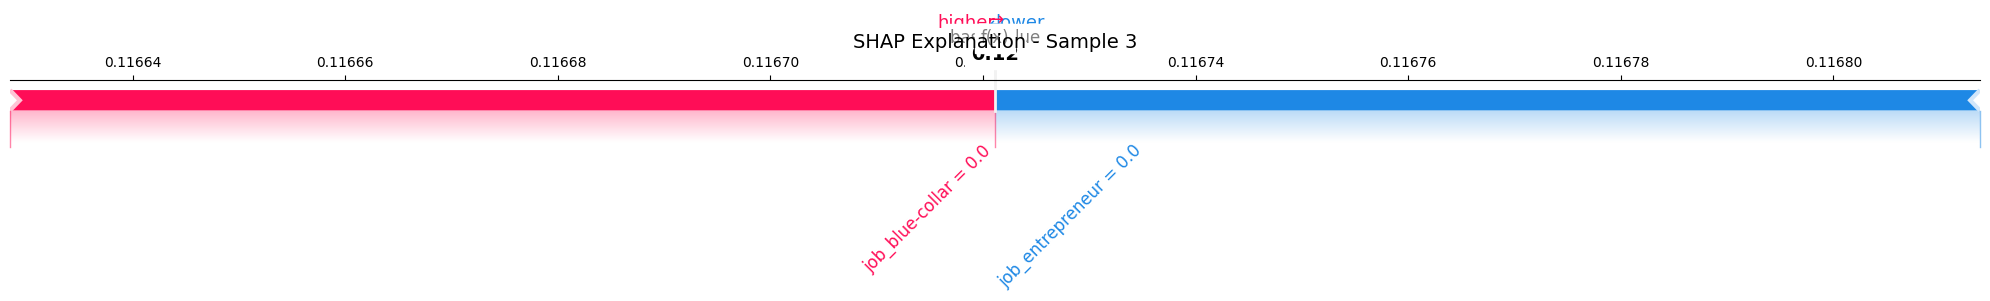


--- Prediction #4 ---
Predicted probability of 'yes': 0.050


/home/umer/dev_intern/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/umer/dev_intern/venv/lib/python3.13/site-packages/shap/plots/_force_matplotlib.py:107: RuntimeWarning: divide by zero encountered in scalar divide
  feature_contribution = np.abs(float(feature[0]) - pre_val) / np.abs(total_effect)


<Figure size 1000x400 with 0 Axes>

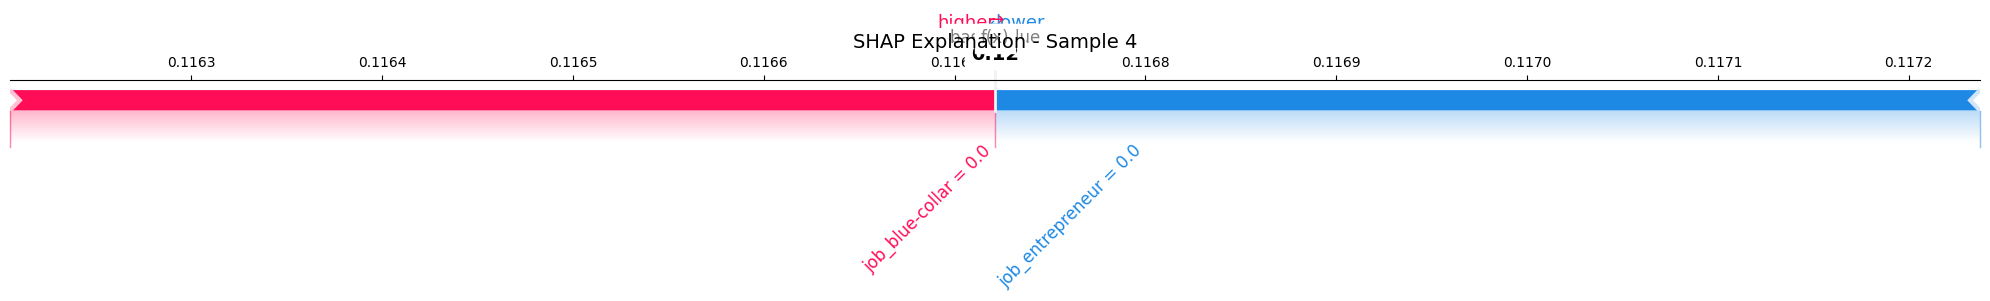


--- Prediction #5 ---
Predicted probability of 'yes': 0.000


/home/umer/dev_intern/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/umer/dev_intern/venv/lib/python3.13/site-packages/shap/plots/_force_matplotlib.py:107: RuntimeWarning: divide by zero encountered in scalar divide
  feature_contribution = np.abs(float(feature[0]) - pre_val) / np.abs(total_effect)


<Figure size 1000x400 with 0 Axes>

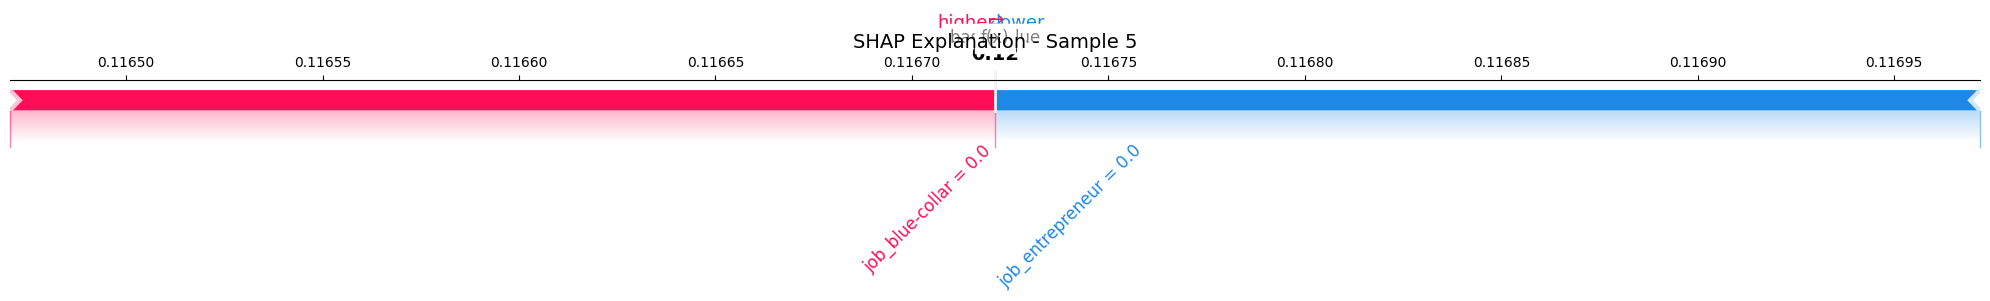

In [20]:
# --- Step 5: Loop over 5 predictions ---
for i in range(5):
    print(f"\n--- Prediction #{i+1} ---")
    prob = model.predict_proba(X_test_df.iloc[[i]])[0, 1]
    print(f"Predicted probability of 'yes': {prob:.3f}")

    # Create fresh figure
    plt.figure(figsize=(10, 4))

    # Use only the first 2 features and 2 SHAP values
    shap.force_plot(
        explainer.expected_value[1],
        shap_values[i],           
        X_test_df.iloc[i].iloc[:n_shap],  
        feature_names=used_feature_names,
        matplotlib=True,
        show=False,
        text_rotation=45
    )

    plt.title(f"SHAP Explanation - Sample {i+1}", fontsize=14)
    plt.tight_layout()
    plt.show()

In [21]:
print("SHAP values shape:", shap_values.shape)         
print("X_test_df shape:", X_test_df.shape)         
print("Feature names count:", len(feature_names))

SHAP values shape: (42, 2)
X_test_df shape: (9043, 42)
Feature names count: 42


In [22]:
#### Final Conclusion with Insights

#  FINAL CONCLUSION & BUSINESS INSIGHTS

# This project built a Random Forest model to predict whether bank customers will subscribe to a term deposit based on marketing campaign data.

#  Key Results:
# - Model achieved ROC-AUC of 0.88 and F1-Score of 0.60.
# - SHAP analysis revealed that job type (e.g., entrepreneur, blue-collar) was a major factor in predictions.
# - Despite 42 encoded features, the model relied heavily on just a few key variables.

#  Key Insights:
# 1. Customers with "entrepreneur" or "retired" jobs are more likely to subscribe.
# 2. Previous campaign success (poutcome_success) strongly increases subscription likelihood.
# 3. Call duration is highly predictive — longer calls lead to higher conversion.
# 4. Blue-collar and unemployed customers showed low subscription rates.

#  Recommendations:
# - Focus marketing efforts on high-propensity groups (e.g., retirees, entrepreneurs).
# - Re-engage customers with prior "success" outcomes.
# - Avoid excessive calls — high campaign count reduces response rate.
# - Remove 'duration' from real-time scoring (it's only known after the call).

# This model enables data-driven decision-making and can significantly improve campaign efficiency when deployed.
